In [2]:
import matplotlib.pyplot as plt
import gromacs as gro
from matplotlib.ticker import MultipleLocator
import pandas as pd
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry.distance import compute_distances, compute_distances_t
import numpy as np
import json

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [12]:
xvg = gro.fileformats.XVG('./rdf_O.xvg')
dataO = xvg.array
dataO.shape

(5, 830)

In [13]:
xvg = gro.fileformats.XVG('./rdf_H.xvg')
dataH = xvg.array
dataH.shape

(5, 830)

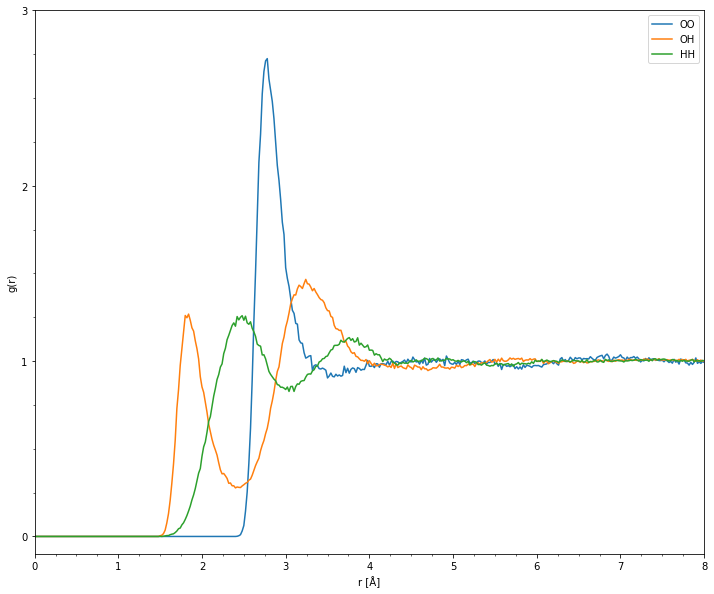

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.plot(dataO[0,:]*10, dataO[1,:], label='OO')
plt.plot(dataO[0,:]*10, dataO[4,:], label='OH')
plt.plot(dataH[0,:]*10, dataH[4,:], label='HH')

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlim(0,8)
plt.ylim(-0.1,3)
plt.xlabel('r [Å]')
plt.ylabel('g(r)')
plt.legend();

In [15]:
df = pd.read_excel('./atomic_form_factors.xlsx')
df = df.drop(['Unnamed: 1','a1','b1','a2','b2','a3','b3','a4','b4','c','Maximum error', 'Q', 'Mean error'], axis=1)
df = df.rename(columns={'Unnamed: 0' : 'atom'})
df = df.set_index('atom')
df.head()

,f(0)
atom,
H,0.999953
H,0.999872
H1-,1.998454
He,1.999900
Li,2.999500


In [16]:
form_factors = df.to_dict()
form_factors = form_factors['f(0)']

with open("form_factors.json", "w") as outfile:
    json.dump(form_factors, outfile)

form_factors

{'H': 0.9998720000000001,
 'H1-': 1.9984540000000002,
 'He': 1.9998999999999998,
 'Li': 2.9995000000000003,
 'Li1+': 1.9999999999999998,
 'Be': 4.0002,
 'Be2+': 1.9999999999999991,
 'B': 4.998600000000001,
 'C': 5.9992,
 'Cval': 5.999326,
 'N': 6.994599999999998,
 'O': 7.9994000000000005,
 'O1-': 8.99222,
 'F': 8.9993,
 'F1-': 9.997512000000002,
 'Ne': 9.998999999999999,
 'Na': 10.9924,
 'Na1+': 9.9997,
 'Mg': 11.9865,
 'Mg2+': 10.000000000000002,
 'Al': 12.993699999999999,
 'Al3+': 9.999962999999997,
 'Siv': 13.997600000000002,
 'Sival': 13.99906,
 'Si4+': 9.999987,
 'P': 14.9993,
 'S': 15.9998,
 'Cl': 17.000500000000002,
 'Cl1-': 17.9942,
 'Ar': 17.9994,
 'K': 18.999,
 'K1+': 18.002200000000002,
 'Ca': 20.0,
 'Ca2+': 18.002500000000005,
 'Sc': 20.998699999999996,
 'Sc3+': 18.000190000000003,
 'Ti': 21.9972,
 'Ti2+': 20.000324,
 'Ti3+': 18.99881,
 'Ti4+': 18.00034,
 'V': 22.995499999999996,
 'V2+': 21.000600000000002,
 'V3+': 20.00017,
 'V5+': 17.99989,
 'Cr': 23.9937,
 'Cr2+': 21.999

In [17]:
def compute_rdf(traj, pairs, r_range=None, bin_width=0.005, n_bins=None,
                periodic=True, opt=True, scaling_factors=None, avg_form_factor=None):
    """Compute radial distribution functions for pairs in every frame.
    Parameters
    ----------
    traj : Trajectory
        Trajectory to compute radial distribution function in.
    pairs : array-like, shape=(n_pairs, 2), dtype=int
        Each row gives the indices of two atoms.
    r_range : array-like, shape=(2,), optional, default=(0.0, 1.0)
        Minimum and maximum radii.
    bin_width : float, optional, default=0.005
        Width of the bins in nanometers.
    n_bins : int, optional, default=None
        The number of bins. If specified, this will override the `bin_width`
         parameter.
    periodic : bool, default=True
        If `periodic` is True and the trajectory contains unitcell
        information, we will compute distances under the minimum image
        convention.
    opt : bool, default=True
        Use an optimized native library to compute the pair wise distances.
    Returns
    -------
    r : np.ndarray, shape=(np.diff(r_range) / bin_width - 1), dtype=float
        Radii values corresponding to the centers of the bins.
    g_r : np.ndarray, shape=(np.diff(r_range) / bin_width - 1), dtype=float
        Radial distribution function values at r.
    See also
    --------
    Topology.select_pairs
    """
    if r_range is None:
        r_range = np.array([0.0, 1.0])
    r_range = ensure_type(r_range, dtype=np.float64, ndim=1, name='r_range',
                          shape=(2,), warn_on_cast=False)
    if n_bins is not None:
        n_bins = int(n_bins)
        if n_bins <= 0:
            raise ValueError('`n_bins` must be a positive integer')
    else:
        n_bins = int((r_range[1] - r_range[0]) / bin_width)
    
    distances = compute_distances(traj, pairs, periodic=periodic, opt=opt)
    
    if scaling_factors is None and avg_form_factor is None:
        print('Original calculation... SLOW')
        scaled_distances = scale_distances(traj, pairs, distances, json_factors='./form_factors.json')
    elif scaling_factors is None:
        print('Pre-calculated average form factor')
        print('\tAverage form factor: ', avg_form_factor)
        scaled_distances = scale_distances_noAvg(traj, pairs, distances, json_factors='./form_factors.json')
        scaled_distances = scaled_distances / avg_form_factor**2
    else:
        print('Pre-calculated scaling factors')
        scaled_distances = distances * scaling_factors        
    
    g_r, edges = np.histogram(scaled_distances, range=r_range, bins=n_bins)
    r = 0.5 * (edges[1:] + edges[:-1])

    # Normalize by volume of the spherical shell.
    # See discussion https://github.com/mdtraj/mdtraj/pull/724. There might be
    # a less biased way to accomplish this. The conclusion was that this could
    # be interesting to try, but is likely not hugely consequential. This method
    # of doing the calculations matches the implementation in other packages like
    # AmberTools' cpptraj and gromacs g_rdf.
    V = (4 / 3) * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = len(pairs) * np.sum(1.0 / traj.unitcell_volumes) * V
    g_r = g_r.astype(np.float64) / norm  # From int64.
    return r, g_r

In [18]:
def scale_distances(traj, pairs, distances, json_factors='./form_factors.json'):
    
    form_factors = json.load(open(json_factors))
    top = traj.topology
    
    scaled_distances = np.zeros(distances.shape)
    elements = {}
    indices = []
    for p, pair in enumerate(pairs):
        atom_i = top.atom(pair[0])
        atom_j = top.atom(pair[1])
        
        element_i = atom_i.element.symbol
        element_j = atom_j.element.symbol
        
        f_i = form_factors[element_i]
        f_j = form_factors[element_j]
        
        scaled_distances[:,p] = distances[:,p]*f_i*f_j
        
        if element_i not in elements and pair[0] not in indices:
            elements[element_i] = 1
            indices.append(pair[0])
        elif pair[0] not in indices:
            elements[element_i] += 1
            indices.append(pair[0])
        if element_j not in elements and pair[1] not in indices:
            elements[element_j] = 1
            indices.append(pair[1])
        elif pair[1] not in indices:
            elements[element_j] += 1
            indices.append(pair[1])
                        
    avg_f = 0
    tot_elem = 0
    for element in elements:
        avg_f += elements[element]*form_factors[element]
        tot_elem += elements[element]

    avg_f = avg_f / tot_elem
    scaled_distances = scaled_distances / avg_f**2
    print('\tAverage form factor:', avg_f)
        
    return scaled_distances


def scale_distances_noAvg(traj, pairs, distances, json_factors='./form_factors.json'):
    
    form_factors = json.load(open(json_factors))
    top = traj.topology
    
    scaled_distances = np.zeros(distances.shape)
    for p, pair in enumerate(pairs):
        atom_i = top.atom(pair[0])
        atom_j = top.atom(pair[1])
        
        element_i = atom_i.element.symbol
        element_j = atom_j.element.symbol
        
        f_i = form_factors[element_i]
        f_j = form_factors[element_j]
        
        scaled_distances[:,p] = distances[:,p]*f_i*f_j
        
    return scaled_distances

Pre-calculated scaling factors
	Average form factor:  3.3330480000002196
Pre-calculated scaling factors
	Average form factor:  3.3330480000002196
Pre-calculated scaling factors
	Average form factor:  3.3330480000002196


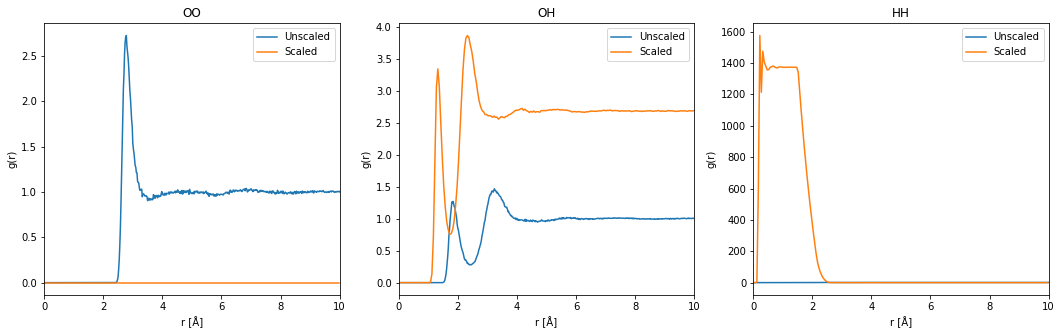

In [23]:
# Testing scaling with pre-calculated factors
t = md.load('../npt.xtc', top='../npt.gro')
top = t.topology

O_idx = [atom.index for atom in top.atoms if atom.element.symbol == 'O']
H_idx = [atom.index for atom in top.atoms if atom.element.symbol == 'H']

OO_pairs = []
OH_pairs = []
HH_pairs = []

OO_scaling = []
OH_scaling = []
HH_scaling = []

idx = O_idx + H_idx
avg_f = 0
count = 0
for i in idx:
    f_i = form_factors[top.atom(i).element.symbol]
    avg_f += f_i
    count += 1
    
avg_f = avg_f / count
    
# Find OO pairs, calculate average OO form factor, and pre-calculate form factors
OO_avg_f = 0
count = 0
for i in O_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    OO_avg_f += f_i
    count += 1
    for j in O_idx:
        if i != j:
            f_j = form_factors[top.atom(j).element.symbol]
            OO_pairs.append([i,j])
            OO_scaling.append(f_i*f_j)
            
# OO_avg_f = OO_avg_f / count
OO_avg_f = avg_f
OO_scaling = np.array(OO_scaling) / OO_avg_f**2
            
# Find OH pairs and pre-calculate form factors
for i in O_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    for j in H_idx:
        if top.atom(i).residue != top.atom(j).residue:
            f_j = form_factors[top.atom(j).element.symbol]
            OH_pairs.append([i,j])
            OH_scaling.append(f_i*f_j)

# # Calculate average OH form factor
# OH_avg_f = 0
# count = 0
# for i in O_idx:
#     f_i = form_factors[top.atom(i).element.symbol]
#     OH_avg_f += f_i
#     count += 1
    
# for j in H_idx:
#     f_j = form_factors[top.atom(j).element.symbol]
#     OH_avg_f += f_j
#     count += 1

# OH_avg_f = OH_avg_f / count
OH_avg_f = avg_f
OH_scaling = np.array(OH_scaling) / OH_avg_f**2

# Find HH pairs, calculate average HH form factor, and pre-calculate form factors
HH_avg_f = 0
count = 0
for i in H_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    HH_avg_f += f_i
    count += 1
    for j in H_idx:
        if i != j and top.atom(i).residue != top.atom(j).residue:
            f_j = form_factors[top.atom(j).element.symbol]
            HH_pairs.append([i,j])
            HH_scaling.append(f_i*f_j)
            
# HH_avg_f = HH_avg_f / count
HH_avg_f = avg_f
HH_scaling = np.array(HH_scaling) / HH_avg_f**2


# Compute RDFs
r_OO, g_OO = compute_rdf(t, OO_pairs, scaling_factors=OO_scaling)
print('\tAverage form factor: ', OO_avg_f)
r_OH, g_OH = compute_rdf(t, OH_pairs, scaling_factors=OH_scaling)
print('\tAverage form factor: ', OH_avg_f)
r_HH, g_HH = compute_rdf(t, HH_pairs, scaling_factors=HH_scaling)
print('\tAverage form factor: ', HH_avg_f)


# Plotting
fig, ax = plt.subplots(1,3, figsize=(18,5))

ax[0].set_title('OO')
ax[0].plot(dataO[0,:]*10, dataO[1,:], label='Unscaled')
ax[0].plot(r_OO*10, g_OO, label='Scaled')

ax[1].set_title('OH')
ax[1].plot(dataO[0,:]*10, dataO[4,:], label='Unscaled')
ax[1].plot(r_OH*10, g_OH, label='Scaled')

ax[2].set_title('HH')
ax[2].plot(dataH[0,:]*10, dataH[4,:], label='Unscaled')
ax[2].plot(r_HH*10, g_HH, label='Scaled')
                
for i in range(3):
    ax[i].set_xlim(0,10)
    ax[i].set_xlabel('r [Å]')
    ax[i].set_ylabel('g(r)')
    ax[i].legend();

In [ ]:
# Testing with precalculating average form factor only
t = md.load('../npt.xtc', top='../npt.gro')
top = t.topology

O_idx = [atom.index for atom in top.atoms if atom.element.symbol == 'O']
H_idx = [atom.index for atom in top.atoms if atom.element.symbol == 'H']

OO_pairs = []
OH_pairs = []
HH_pairs = []

# Find OO pairs and calculate average OO form factor
OO_avg_f = 0
count = 0
for i in O_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    OO_avg_f += f_i
    count += 1
    for j in O_idx:
        if i != j:
            OO_pairs.append([i,j])
            
OO_avg_f = OO_avg_f / count

# Find OH pairs
for i in O_idx:
    for j in H_idx:
        if top.atom(i).residue != top.atom(j).residue:
            OH_pairs.append([i,j])
            
# Calculate average OH form factor
OH_avg_f = 0
count = 0
for i in O_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    OH_avg_f += f_i
    count += 1
    
for j in H_idx:
    f_j = form_factors[top.atom(j).element.symbol]
    OH_avg_f += f_j
    count += 1

OH_avg_f = OH_avg_f / count

# Find HH pairs and calculate average HH form factor
HH_avg_f = 0
count = 0
for i in H_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    HH_avg_f += f_i
    count += 1
    for j in H_idx:
        if i != j and top.atom(i).residue != top.atom(j).residue:
            HH_pairs.append([i,j])
            
HH_avg_f = HH_avg_f / count

            
# Compute RDFs
r_OO, g_OO = compute_rdf(t, OO_pairs, avg_form_factor=OO_avg_f)
r_OH, g_OH = compute_rdf(t, OH_pairs, avg_form_factor=OH_avg_f)
r_HH, g_HH = compute_rdf(t, HH_pairs, avg_form_factor=HH_avg_f)


# Plotting
fig, ax = plt.subplots(1,3, figsize=(18,5))

ax[0].set_title('OO')
ax[0].plot(dataO[0,:]*10, dataO[1,:], label='Unscaled')
ax[0].plot(r_OO*10, g_OO, label='Scaled')

ax[1].set_title('OH')
ax[1].plot(dataO[0,:]*10, dataO[4,:], label='Unscaled')
ax[1].plot(r_OH*10, g_OH, label='Scaled')

ax[2].set_title('HH')
ax[2].plot(dataH[0,:]*10, dataH[4,:], label='Unscaled')
ax[2].plot(r_HH*10, g_HH, label='Scaled')
                
for i in range(3):
    ax[i].set_xlim(0,10)
    ax[i].set_xlabel('r [Å]')
    ax[i].set_ylabel('g(r)')
    ax[i].legend();

Original calculation... SLOW
	Average form factor: 7.9994000000000005
Original calculation... SLOW
	Average form factor: 3.3330480000000007
Original calculation... SLOW
	Average form factor: 0.9998720000000001


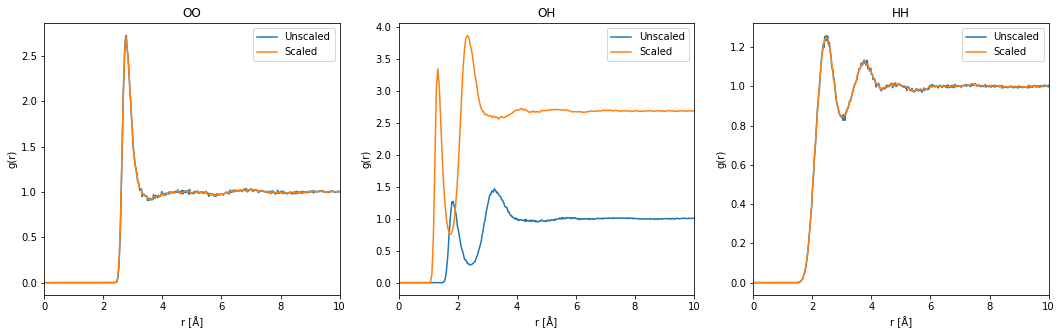

In [30]:
# Original correct scaling (WARNING: SLOW)
t = md.load('../npt.xtc', top='../npt.gro')
top = t.topology

O_idx = [atom.index for atom in top.atoms if atom.element.symbol == 'O']
H_idx = [atom.index for atom in top.atoms if atom.element.symbol == 'H']

OO_pairs = []
OH_pairs = []
HH_pairs = []

for i in O_idx:
    for j in O_idx:
        if i != j:
            OO_pairs.append([i,j])

for i in O_idx:
    for j in H_idx:
        if top.atom(i).residue != top.atom(j).residue:
            OH_pairs.append([i,j])

for i in H_idx:
    for j in H_idx:
        if i != j and top.atom(i).residue != top.atom(j).residue:
            HH_pairs.append([i,j])

r_OO, g_OO = compute_rdf(t, OO_pairs)
r_OH, g_OH = compute_rdf(t, OH_pairs)
r_HH, g_HH = compute_rdf(t, HH_pairs)


fig, ax = plt.subplots(1,3, figsize=(18,5))

ax[0].set_title('OO')
ax[0].plot(dataO[0,:]*10, dataO[1,:], label='Unscaled')
ax[0].plot(r_OO*10, g_OO, label='Scaled')

ax[1].set_title('OH')
ax[1].plot(dataO[0,:]*10, dataO[4,:], label='Unscaled')
ax[1].plot(r_OH*10, g_OH, label='Scaled')

ax[2].set_title('HH')
ax[2].plot(dataH[0,:]*10, dataH[4,:], label='Unscaled')
ax[2].plot(r_HH*10, g_HH, label='Scaled')
                
for i in range(3):
    ax[i].set_xlim(0,10)
    ax[i].set_xlabel('r [Å]')
    ax[i].set_ylabel('g(r)')
    ax[i].legend();

Average form factor: 3.3330480000001796
Pre-calculated scaling factors

--------------------------- TIMING BREAKDOWN ---------------------------
	Finding pairs and calculating scaling factors:	14.494322
	Computing RDFs: 				24.622141

	Total time: 					39.116462
--------------------------------------------------------------------


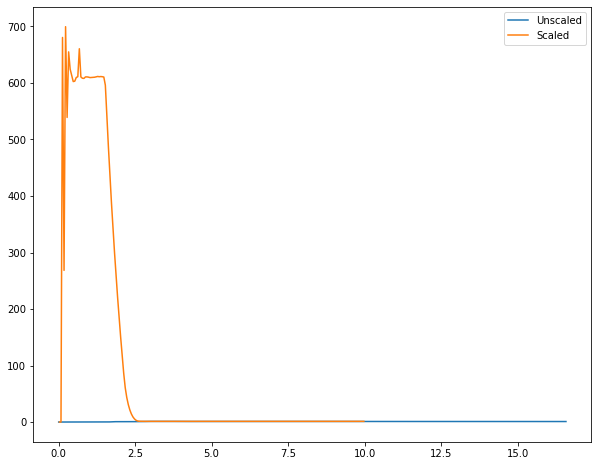

In [68]:
# Time it
from time import time
start = time()

# Put it all together for a system RDF with pre-calculated scaling factors (the fastest!)
atom_idx = [atom.index for atom in top.atoms]

pairs = []
scaling_factors = []

avg_f = 0
count = 0
for i in atom_idx:
    f_i = form_factors[top.atom(i).element.symbol]
    avg_f += f_i
    count += 1
    for j in atom_idx:
        if i != j:# and top.atom(i).residue != top.atom(j).residue:
            f_j = form_factors[top.atom(j).element.symbol]
            pairs.append([i,j])
            scaling_factors.append(f_i*f_j)
            
avg_f = avg_f / count
scaling_factors = np.array(scaling_factors) / avg_f**2
print('Average form factor:', avg_f)
find_pairs = time()

r, g_r = compute_rdf(t, pairs, scaling_factors=scaling_factors)
rdf_comp = time()

print()
print('-'*27 + ' TIMING BREAKDOWN ' + '-'*27)
print('\tFinding pairs and calculating scaling factors:\t%f' %(find_pairs - start) )
print('\tComputing RDFs: \t\t\t\t%f' %(rdf_comp - find_pairs) )
print('\n\tTotal time: \t\t\t\t\t%f' %(rdf_comp - start) )
print('-'*68)

xvg = gro.fileformats.XVG('./rdf.xvg')
data = xvg.array

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(data[0,:]*10, data[1,:], label='Unscaled')
ax.plot(r*10, g_r, label='Scaled')
ax.legend();